# 1. Predicting Rarity With Just Card Data

Question to answer here - how CONSISTENT are Hearthstone developers with their cards?
Complaints of ramping - newly released cards are much more powerful over time. Is this true?

In [237]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats


from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.multiclass import unique_labels
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier


from pactools.grid_search import GridSearchCVProgressBar
import warnings
warnings.filterwarnings("ignore")
# I know - but the gridsearchprogress bar throws a warning every second and its SO LONG.

from string import punctuation
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 

from bs4 import BeautifulSoup
import re
from nltk.stem import WordNetLemmatizer


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

import statsmodels.tools as sm

%matplotlib inline

In [238]:
df = pd.read_csv('dummies_df_card_list.csv')
df.head()

,attack,cardId,cardSet,cost,durability,faction,health,name,playerClass,race,...,race_General,race_Mech,race_Murloc,race_Pirate,race_Totem,type_Hero,type_Minion,type_Spell,type_Weapon,rarity_value
0,-1.0,CS2_041,Basic,0.0,-1.0,Neutral,-1.0,Ancestral Healing,Shaman,General,...,1,0,0,0,0,0,0,1,0,0
1,-1.0,CS2_072,Basic,0.0,-1.0,Neutral,-1.0,Backstab,Rogue,General,...,1,0,0,0,0,0,0,1,0,0
2,-1.0,EX1_169,Basic,0.0,-1.0,Neutral,-1.0,Innervate,Druid,General,...,1,0,0,0,0,0,0,1,0,0
3,-1.0,CS2_008,Basic,0.0,-1.0,Neutral,-1.0,Moonfire,Druid,General,...,1,0,0,0,0,0,0,1,0,0
4,-1.0,NEW1_003,Basic,0.0,-1.0,Neutral,-1.0,Sacrificial Pact,Warlock,General,...,1,0,0,0,0,0,0,1,0,0


In [239]:
list(df.columns)


['attack',
 'cardId',
 'cardSet',
 'cost',
 'durability',
 'faction',
 'health',
 'name',
 'playerClass',
 'race',
 'rarity',
 'text',
 'type',
 'armor',
 'mech_Adapt',
 'mech_AdjacentBuff',
 'mech_AffectedBySpellPower',
 'mech_Aura',
 'mech_Battlecry',
 'mech_Charge',
 'mech_Combo',
 'mech_Deathrattle',
 'mech_Discover',
 'mech_Divine Shield',
 'mech_Echo',
 'mech_Freeze',
 'mech_ImmuneToSpellpower',
 'mech_Inspire',
 'mech_InvisibleDeathrattle',
 'mech_Jade Golem',
 'mech_Lifesteal',
 'mech_Magnetic',
 'mech_Overkill',
 'mech_Overload',
 'mech_Poisonous',
 'mech_Quest',
 'mech_Recruit',
 'mech_Rush',
 'mech_Secret',
 'mech_Silence',
 'mech_Spell Damage',
 'mech_Stealth',
 'mech_Taunt',
 'mech_Twinspell',
 'mech_Windfury',
 'cardset_Basic',
 'cardset_Blackrock Mountain',
 'cardset_Classic',
 'cardset_Goblins vs Gnomes',
 'cardset_Hall of Fame',
 "cardset_Journey to Un'Goro",
 'cardset_Knights of the Frozen Throne',
 'cardset_Kobolds & Catacombs',
 'cardset_Mean Streets of Gadgetzan',


## Linear Regression Model

Linear Regression on raw data:

In [240]:
numerical_columns = df._get_numeric_data().columns
features = [c for c in numerical_columns if c != 'rarity_value']
X = df[features]
y = df['rarity_value']

X = sm.add_constant(X)

In [241]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [242]:
lr = LinearRegression()
model_1 = lr.fit(X_train, y_train)

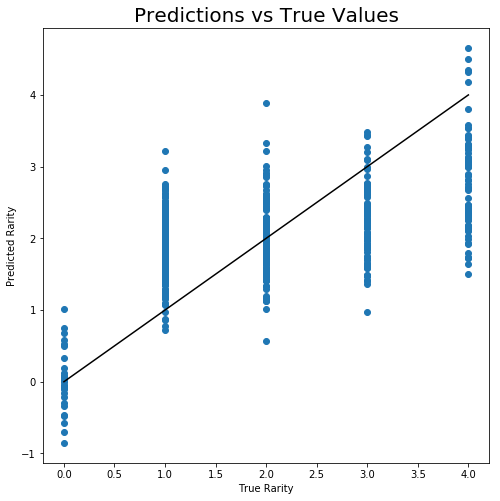

In [243]:
plt.figure(figsize=(8,8))
plt.scatter(y =  model_1.predict(X_test), x = y_test)
plt.title('Predictions vs True Values', fontsize = 20)
plt.xlabel('True Rarity')
plt.ylabel('Predicted Rarity')
plt.plot([0, np.max(y)], [0, np.max(y)], c = 'k');

In [244]:
print('Train Score:', model_1.score(X_train,y_train))
print('Test Score:', model_1.score(X_test,y_test))

Train Score: 0.45344492113491286
Test Score: 0.3663278022653662


Linear Regression on Transformed Data:

In [245]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)


In [246]:
model_2 = lr.fit(X_train_scaled, y_train)

In [247]:
print('Train Score:', model_2.score(X_train_scaled,y_train))
print('Test Score:', model_2.score(X_test_scaled,y_test))

Train Score: 0.4505547924265545
Test Score: 0.35886023791517585


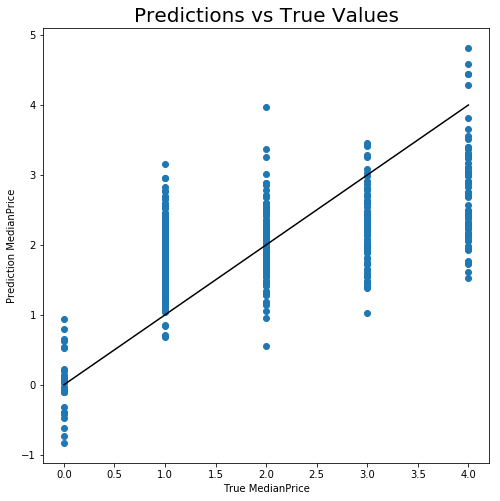

In [248]:
plt.figure(figsize=(8,8))
plt.scatter(y = model_2.predict(X_test_scaled), x = y_test)
plt.title('Predictions vs True Values', fontsize = 20)
plt.xlabel('True MedianPrice')
plt.ylabel('Prediction MedianPrice')
plt.plot([0, np.max(y)], [0, np.max(y)], c = 'k');

Let's quickly take a glance at some of the determining coeffients for this simple model:

In [249]:
model_2_coef_df = pd.DataFrame(model_2.coef_,
                       columns =['coef'])

model_2_coef_df.shape

(82, 1)

In [250]:
features_temp = ['constant'] + features


featuresdf = pd.DataFrame(features_temp,
                      columns = ['feature'])

featuresdf.shape

(82, 1)

In [251]:
pd.concat([model_2_coef_df, featuresdf], axis = 1).sort_values('coef')

,coef,feature
79,-1.872582e+13,type_Minion
80,-1.797357e+13,type_Spell
39,-8.741562e+12,cardset_Classic
73,-8.254444e+12,race_General
81,-7.620753e+12,type_Weapon
42,-7.248178e+12,cardset_Journey to Un'Goro
48,-7.097272e+12,cardset_Rastakhan's Rumble
54,-7.066561e+12,cardset_Whispers of the Old Gods
37,-7.004590e+12,cardset_Basic
50,-6.941871e+12,cardset_The Boomsday Project


Well that was fun to play around with and to get SOMETHING - but really this model is not telling us much at all, even looking at the coefficients. Let's get a multiclass classification model in here - maybe even a feed forward neural network!

## Logistic Regression - Multiclass

In [252]:
#Baseline:
y.value_counts()
#unbalanced class - something to consider!

1    713
2    519
3    339
4    299
0    133
Name: rarity_value, dtype: int64

In [253]:
logr = LogisticRegression()
ss = StandardScaler()

X_train, X_test, y_train, y_test  = train_test_split(X, y, random_state = 42, stratify = y)

X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

In [254]:
y_test.value_counts()

1    178
2    130
3     85
4     75
0     33
Name: rarity_value, dtype: int64

In [255]:
model_3 = logr.fit(X_train_scaled, y_train)

In [256]:
print('LogReg score on Train:', model_3.score(X_train_scaled, y_train))
print('LogReg score on Test:', model_3.score(X_test_scaled, y_test))

LogReg score on Train: 0.5692410119840213
LogReg score on Test: 0.499001996007984


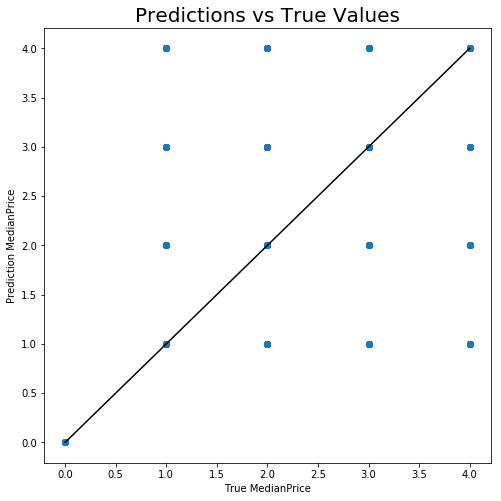

In [257]:
plt.figure(figsize=(8,8))
plt.scatter(y = model_3.predict(X_test_scaled), x = y_test)
plt.title('Predictions vs True Values', fontsize = 20)
plt.xlabel('True MedianPrice')
plt.ylabel('Prediction MedianPrice')
plt.plot([0, np.max(y)], [0, np.max(y)], c = 'k');

# lol useless - lets look at a confusion matrix!

Text(0.5,1,'Confusion Matrix')

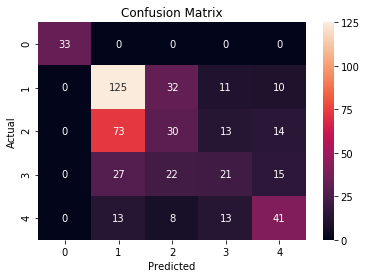

In [261]:
y_true = y_test
y_pred = model_3.predict(X_test_scaled)

sns.heatmap(confusion_matrix(y_true, y_pred),
           annot = True, fmt = 'd', )
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

Train Accuracy: 0.5692410119840213
Test Accuracy: 0.499001996007984


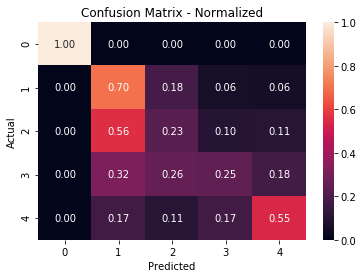

In [264]:
sns.heatmap(confusion_matrix(y_true, y_pred).astype('float') / confusion_matrix(y_true, y_pred).sum(axis=1)[:, np.newaxis],
           annot = True, fmt = '.2f', )
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Normalized')

print('Train Accuracy:', model_3.score(X_train_scaled, y_train))
print('Test Accuracy:', model_3.score(X_test_scaled, y_test))



In [275]:
# THESE ARE THE COEFFICIENTS THAT PREDICT THE 0 CLASS! :O
model_3.coef_[0]

array([ 0.00e+00,  2.32e-02, -3.62e-02, -2.62e-03, -2.89e-02,  3.39e-03,
       -1.14e-02,  2.24e-02, -2.10e-02,  1.73e-02, -2.67e-02,  3.07e-02,
       -1.39e-02, -4.29e-02, -2.51e-02, -1.88e-02, -2.18e-02,  1.00e-03,
        6.41e-03, -1.23e-02, -7.59e-03, -9.66e-03, -1.89e-02,  1.02e-03,
       -9.47e-03, -2.08e-02, -1.53e-02, -1.67e-02, -5.45e-03, -1.22e-02,
       -3.61e-02, -2.20e-02,  1.63e-02, -2.98e-02,  2.10e-02, -1.67e-02,
        4.77e-04,  2.59e+00, -8.82e-02, -2.70e-01, -1.72e-01, -8.59e-02,
       -1.86e-01, -1.82e-01, -1.87e-01, -1.85e-01, -8.16e-02, -1.06e-01,
       -1.66e-01, -1.83e-01, -1.82e-01, -1.87e-01, -1.04e-01, -1.78e-01,
       -1.88e-01,  1.64e-02,  5.84e-02, -4.75e-02, -2.02e-03,  4.01e-03,
       -1.33e-02,  9.10e-03,  4.72e-03,  1.46e-03,  2.33e-03, -9.92e-03,
       -8.36e-03,  4.33e-03, -4.10e-03,  1.01e-02, -8.19e-03, -3.68e-03,
       -8.94e-03,  5.76e-03, -1.96e-02,  2.53e-02, -1.16e-02,  1.74e-02,
        9.29e-03, -4.02e-02,  3.92e-02,  2.11e-03])

In [278]:
len(X.columns)

82

In [284]:
coef_0_pred = list(model_3.coef_[0])
feature_list = X.columns
logreg_pred_0_df =  pd.DataFrame({'coef':coef_0_pred,'feature':feature_list})
logreg_pred_0_df.sort_values(by = 'coef', ascending = False).head()

,coef,feature
37,2.585011,cardset_Basic
56,0.058437,faction_Horde
80,0.039245,type_Spell
11,0.030682,mech_Charge
75,0.025265,race_Murloc


OH yep. That makes sense - totally forgot that all of the Free cards are in the Basic set - that's....why it's called Basic. That's pretty hilarious. But we can see the other classes are 'meh' at best, so let's get some NLP!

## NLP Time

Help from Dave's NLP walkthrough and here:
https://stackoverflow.com/questions/47423854/sklearn-adding-lemmatizer-to-countvectorizer?rq=1

In [167]:
df.head()

,attack,cardId,cost,durability,health,name,rarity,text,armor,mech_Adapt,...,race_General,race_Mech,race_Murloc,race_Pirate,race_Totem,type_Hero,type_Minion,type_Spell,type_Weapon,rarity_value
0,-1.0,CS2_041,0.0,-1.0,-1.0,Ancestral Healing,Free,Restore a minion\nto full Health and\ngive it ...,-1.0,0.0,...,1,0,0,0,0,0,0,1,0,0
1,-1.0,CS2_072,0.0,-1.0,-1.0,Backstab,Free,Deal $2 damage to an undamaged minion.,-1.0,0.0,...,1,0,0,0,0,0,0,1,0,0
2,-1.0,EX1_169,0.0,-1.0,-1.0,Innervate,Free,Gain 1 Mana Crystal this turn only.,-1.0,0.0,...,1,0,0,0,0,0,0,1,0,0
3,-1.0,CS2_008,0.0,-1.0,-1.0,Moonfire,Free,Deal $1 damage.,-1.0,0.0,...,1,0,0,0,0,0,0,1,0,0
4,-1.0,NEW1_003,0.0,-1.0,-1.0,Sacrificial Pact,Free,Destroy a Demon. Restore #5 Health to your hero.,-1.0,0.0,...,1,0,0,0,0,0,0,1,0,0


In [168]:
df['text'][1704]

'<b>Taunt</b>\\n<b>Battlecry:</b> Deal 6 damage to this minion.'

We need stop words - I've already played around with this a BUNCH. ngram length and stop words change the upcoming graphs drastically. A lot of words in the default stop words list are actually VITAL in hearthstone - YOUR minion vs A minion are hugely different. I'm going to remove certain words from the stopword list:

List found here: https://gist.github.com/sebleier/554280

removed:
 - "your", "yours", "you"
 - itself
 - "a", "an"
 - "they", "them", "their", "theirs", "themselves"
 -  "or", "and"
 - "during", "before"
 - "this", "that",

In [169]:
custom_stop_words = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you",
 "yourself", "yourselves", "he", "him", "his", "himself",
 "she", "her", "hers", "herself", "it", "its",  "what", "which", "who", "whom", 
 "these", "those", "am", "is", "are", "was", "were", "be", "been", "being",
 "have", "has", "had", "having", "do", "does", "did", "doing",  "the",
  "but",  "because", "as", "until", "while", "of", "at", "by", "if"
 "for", "with", "about", "against", "between", "into", "through", 
 "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", 
 "over", "under", "again", "further", "then", "once", "here", "there", "when", 
 "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", 
 "other", "some", "such", "no", "nor", "not","only", "own", "same", "so", 
 "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]

In [170]:
def post_to_words(raw_post):

    # 1. Remove HTML.
    #beaut_text = BeautifulSoup(raw_post, 'lxml').get_text()
    
    # 2. Remove the '\n' string:
    raw_post = raw_post.replace('\\n', ' ')
    raw_post = raw_post.replace('\n', ' ')
    raw_post = raw_post.replace('<b>',' ')
    raw_post = raw_post.replace('</b>',' ')
    raw_post = raw_post.replace("’", '')
    
    
    # 4. Remove non-letters.
    #letters_only = re.sub("[^a-zA-Z]", " ", beaut_text)
    
    # 5. Convert to lower case, split into individual words.
    #words = beaut_text.lower().split()

    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return raw_post.translate(str.maketrans('', '', punctuation))

In [171]:
test = df['text'][1704]
test

'<b>Taunt</b>\\n<b>Battlecry:</b> Deal 6 damage to this minion.'

In [172]:
post_to_words(test)

' Taunt   Battlecry  Deal 6 damage to this minion'

In [173]:
df['text'] = df['text'].apply(post_to_words)


In [174]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

cvec = CountVectorizer(tokenizer=LemmaTokenizer(),
                                ngram_range = (3,5),
                                strip_accents = 'unicode', # works 
                                stop_words = custom_stop_words, # works
                                lowercase = True) # works
                    

In [175]:
text_vect = cvec.fit_transform(df['text'])
text_vect_df = pd.DataFrame(text_vect.toarray(), columns = cvec.get_feature_names())
text_vect_df.set_index(df['rarity'], inplace=True)

In [176]:
text_vect_df.head()

,0 battlecry discover,0 battlecry discover a,0 battlecry discover a spell,0 if your,0 if your hero,0 if your hero wa,0 if youre,0 if youre holding,0 if youre holding a,0 if youve,...,youve played thisgame,youve restored 10,youve restored 10 health,youve restored 10 health this,youve restored 5,youve restored 5 health,youve restored 5 health this,youve spent spell,youve summoned this,youve summoned this game
rarity,,,,,,,,,,,,,,,,,,,,,
Free,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Free,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Free,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Free,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Free,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [177]:
top_free_features = text_vect_df.loc['Free'].sum().sort_values(ascending = False)[:30]
top_common_features = text_vect_df.loc['Common'].sum().sort_values(ascending = False)[:30]
top_rare_features = text_vect_df.loc['Rare'].sum().sort_values(ascending = False)[:30]
top_epic_features = text_vect_df.loc['Epic'].sum().sort_values(ascending = False)[:30]
top_legendary_features = text_vect_df.loc['Legendary'].sum().sort_values(ascending = False)[:30]

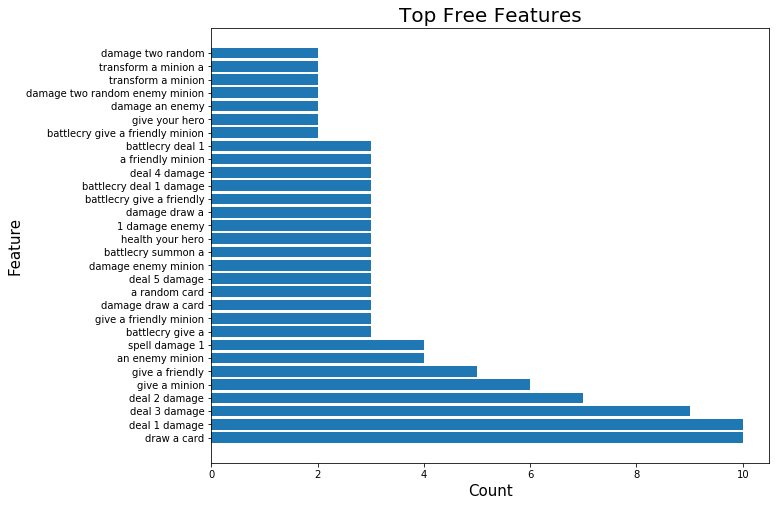

In [178]:
plt.figure(figsize = (10, 8))
plt.barh(top_free_features.index, top_free_features.values)
plt.title('Top Free Features', fontsize = 20)
plt.xlabel('Count', fontsize = 15)
plt.ylabel('Feature', fontsize = 15)
plt.show()

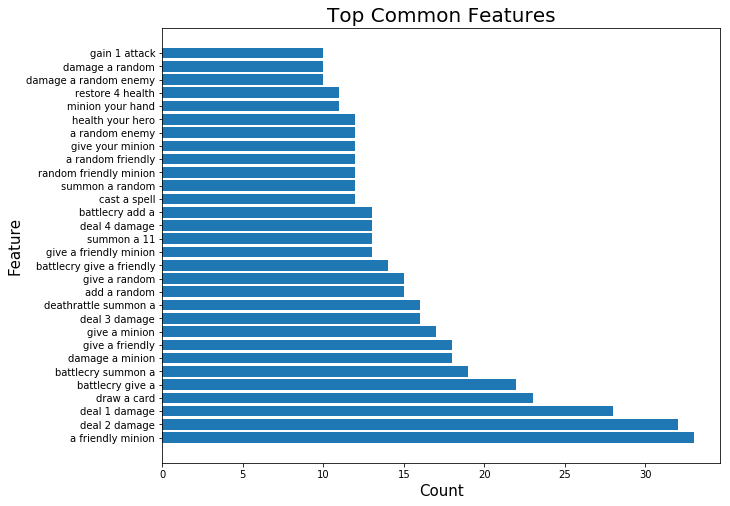

In [179]:
plt.figure(figsize = (10, 8))
plt.barh(top_common_features.index, top_common_features.values)
plt.title('Top Common Features', fontsize = 20)
plt.xlabel('Count', fontsize = 15)
plt.ylabel('Feature', fontsize = 15)
plt.show()

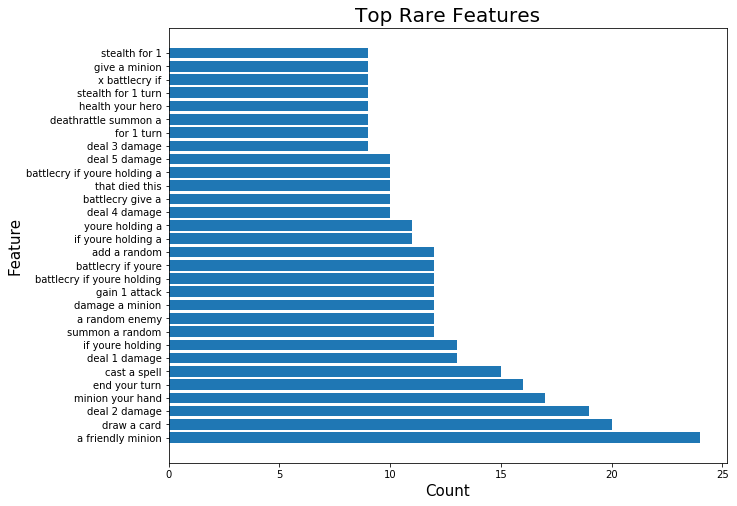

In [180]:
plt.figure(figsize = (10, 8))
plt.barh(top_rare_features.index, top_rare_features.values)
plt.title('Top Rare Features', fontsize = 20)
plt.xlabel('Count', fontsize = 15)
plt.ylabel('Feature', fontsize = 15)
plt.show()

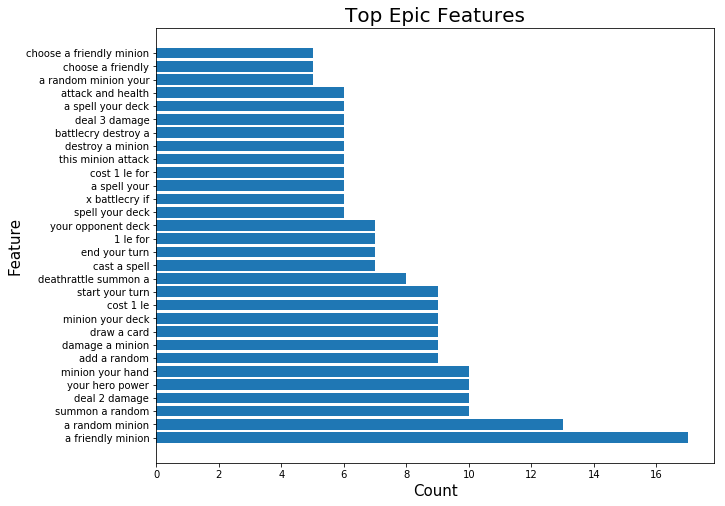

In [181]:
plt.figure(figsize = (10, 8))
plt.barh(top_epic_features.index, top_epic_features.values)
plt.title('Top Epic Features', fontsize = 20)
plt.xlabel('Count', fontsize = 15)
plt.ylabel('Feature', fontsize = 15)
plt.show()

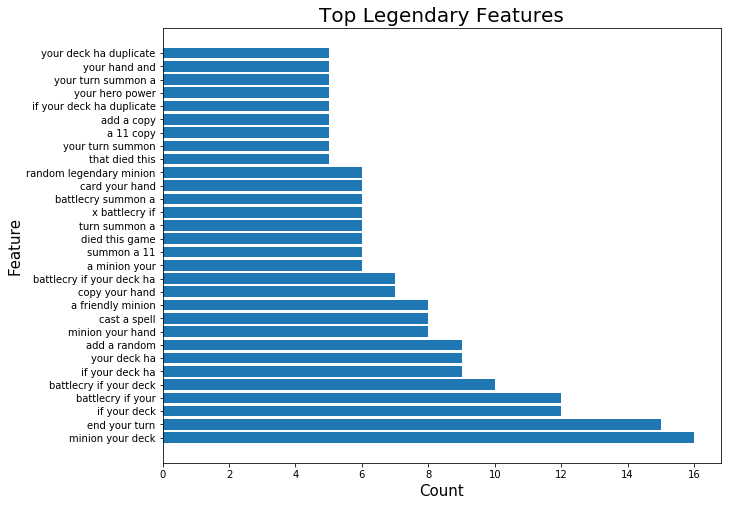

In [182]:
plt.figure(figsize = (10, 8))
plt.barh(top_legendary_features.index, top_legendary_features.values)
plt.title('Top Legendary Features', fontsize = 20)
plt.xlabel('Count', fontsize = 15)
plt.ylabel('Feature', fontsize = 15)
plt.show()

This looks the best! Let's try some models.

In [183]:
# set up X and y

X = text_vect_df
y = text_vect_df.index

In [184]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [185]:
logreg = LogisticRegression()
model_4 = logreg.fit(X_train, y_train)

train_score = round(model_4.score(X_train, y_train), 5)
test_score = round(model_4.score(X_test, y_test), 5)

print('train score:', train_score)
print('test score:', test_score)



train score: 0.9465
test score: 0.3594


Text(0.5,1,'Confusion Matrix')

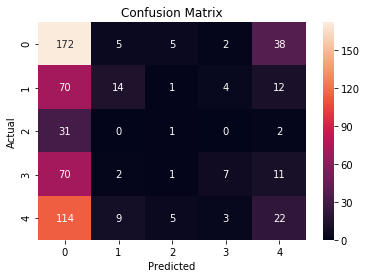

In [186]:
y_true = y_test
y_pred = model_4.predict(X_test)

sns.heatmap(confusion_matrix(y_true, y_pred),
           annot = True, fmt = 'd', )
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

We DEFINITELY need to regularize. 

# Optimizing Using Pipelines and Regularization

## Predicting Rarity

In [187]:
X = df['text']
y = df['rarity_value']

X_train, X_test, y_train, y_test = train_test_split(X, y ,
                                                        test_size = 0.25,
                                                        stratify = y,
                                                        random_state = 42)

## CVEC and LogReg

In [188]:
# MAKE A PIPELINE WITH DIFFERENT VECTORIZES AND MODELS

pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression(random_state = 42))
])

params = {
    'cvec__max_features': [200,500,1000,1500],
    'cvec__tokenizer': [LemmaTokenizer()],
    'cvec__stop_words': [custom_stop_words, 'english'],
    'cvec__lowercase': [True],
    'cvec__ngram_range': [(1,2), (2,3), (3,4)],
    'lr__penalty':['l1','l2'],
    'lr__class_weight': [None, 'balanced']
}

gs1 = GridSearchCVProgressBar(pipe, params, cv = 3, verbose = 1)

gs1.fit(X_train, y_train);


Fitting 3 folds for each of 96 candidates, totalling 288 fits
[                                        ] 0% | 0.00 sec | GridSearchCV 

[ParallelProgressBar(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[........................................] 100% | 167.50 sec | GridSearchCV 


[ParallelProgressBar(n_jobs=1)]: Done 288 out of 288 | elapsed:  2.8min finished


In [189]:
def model_metrics(model_name):
    print('Train Accuracy:', model_name.score(X_train, y_train))
    print('Test Accuracy:', model_name.score(X_test, y_test))
    print('')

    y_true = y_test
    y_pred = model_name.predict(X_test)
    

    sns.heatmap(confusion_matrix(y_true, y_pred),
           annot = True, fmt = 'd', )
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    
    plt.show()
    
  
    sns.heatmap(confusion_matrix(y_true, y_pred).astype('float') / confusion_matrix(y_true, y_pred).sum(axis=1)[:, np.newaxis],
           annot = True, fmt = '.2f', )
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix - Normalized')
    
    plt.show()
    
    
    

In [190]:
print("max features:", gs1.best_params_.get('cvec__max_features'))
print("stop words:", gs1.best_params_.get('cvec__stop_words'))
print("ngram range:", gs1.best_params_.get('cvec__ngram_range'))
print("LogReg penalty:", gs1.best_params_.get('lr__penalty'))
print("LogReg class weight:", gs1.best_params_.get('lr__class_weight'))



max features: 500
stop words: english
ngram range: (1, 2)
LogReg penalty: l2
LogReg class weight: None


Train Accuracy: 0.6657789613848203
Test Accuracy: 0.4231536926147705



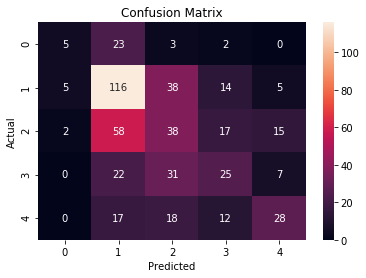

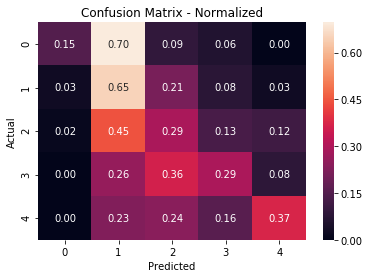

In [191]:
model_metrics(gs1)

## TiffyDif and LogReg

In [192]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression(random_state = 42))
])

params = {
    'tvec__max_features': [200,500,1000,1500],
    'tvec__tokenizer': [LemmaTokenizer()],
    'tvec__stop_words': [custom_stop_words, 'english'],
    'tvec__lowercase': [True],
    'tvec__ngram_range': [(1,2), (2,3), (3,4)],
    'lr__penalty':['l1','l2'],
    'lr__class_weight': [None, 'balanced']
}

gs2 = GridSearchCVProgressBar(pipe, params, cv = 3, verbose = 1)

gs2.fit(X_train, y_train);


Fitting 3 folds for each of 96 candidates, totalling 288 fits
[                                        ] 0% | 0.00 sec | GridSearchCV 

[ParallelProgressBar(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[........................................] 100% | 166.36 sec | GridSearchCV 


[ParallelProgressBar(n_jobs=1)]: Done 288 out of 288 | elapsed:  2.8min finished


In [193]:
print("max features:", gs2.best_params_.get('tvec__max_features'))
print("stop words:", gs2.best_params_.get('tvec__stop_words'))
print("ngram range:", gs2.best_params_.get('tvec__ngram_range'))
print("LogReg penalty:", gs2.best_params_.get('lr__penalty'))
print("LogReg class weight:", gs2.best_params_.get('lr__class_weight'))


max features: 500
stop words: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'what', 'which', 'who', 'whom', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'the', 'but', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'iffor', 'with', 'about', 'against', 'between', 'into', 'through', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now']
ngram range: (1, 2)
LogReg penalty: l2
LogReg class weight: None


Train Accuracy: 0.5818908122503329
Test Accuracy: 0.4251497005988024



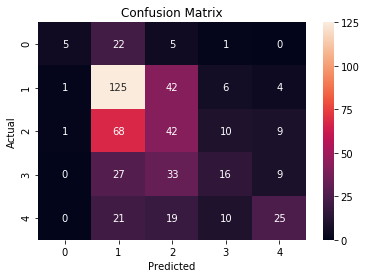

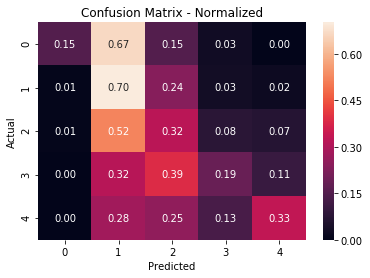

In [194]:
model_metrics(gs2)

## CVEC and Multinomial

In [195]:
# MAKE A PIPELINE WITH DIFFERENT VECTORIZES AND MODELS

pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('mnb', MultinomialNB())
])

params = {
    'cvec__max_features': [200,500,1000,1500],
    'cvec__tokenizer': [LemmaTokenizer()],
    'cvec__stop_words': [custom_stop_words, 'english'],
    'cvec__lowercase': [True],
    'cvec__ngram_range': [(1,2), (2,3), (3,4)],
}

gs3 = GridSearchCVProgressBar(pipe, params, cv = 3, verbose = 1)

gs3.fit(X_train, y_train);

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[                                        ] 0% | 0.00 sec | GridSearchCV 

[ParallelProgressBar(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[........................................] 100% | 41.99 sec | GridSearchCV 


[ParallelProgressBar(n_jobs=1)]: Done  72 out of  72 | elapsed:   42.0s finished


max features: 1500
stop words: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'what', 'which', 'who', 'whom', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'the', 'but', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'iffor', 'with', 'about', 'against', 'between', 'into', 'through', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now']
ngram range: (1, 2)
Train Accuracy: 0.6637816245006658
Test Accuracy: 0.41317365269461076



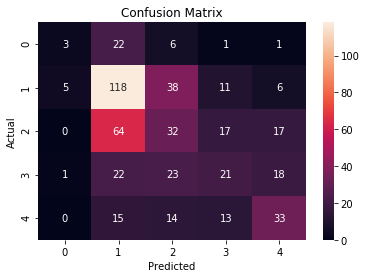

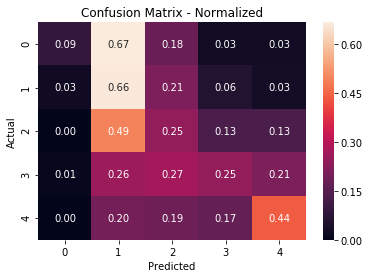

In [196]:
print("max features:", gs3.best_params_.get('cvec__max_features'))
print("stop words:", gs3.best_params_.get('cvec__stop_words'))
print("ngram range:", gs3.best_params_.get('cvec__ngram_range'))

model_metrics(gs3)


## Bagging K Neighbors? Just to Try

In [204]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('bag', BaggingClassifier())
])

params = {
    'cvec__max_features': [200,500,1000,1500],
    'cvec__tokenizer': [LemmaTokenizer()],
    'cvec__stop_words': [custom_stop_words],
    'cvec__lowercase': [True],
    'cvec__ngram_range': [(1,2), (2,3)],
    'bag__base_estimator': [None, KNeighborsClassifier(n_neighbors=15)]
}

gs4 = GridSearchCVProgressBar(pipe, params, cv = 3, verbose = 1)

gs4.fit(X_train, y_train);

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[                                        ] 0% | 0.00 sec | GridSearchCV 

[ParallelProgressBar(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[........................................] 100% | 50.58 sec | GridSearchCV 


[ParallelProgressBar(n_jobs=1)]: Done  48 out of  48 | elapsed:   50.6s finished


Train Accuracy: 0.9394141145139814
Test Accuracy: 0.3712574850299401



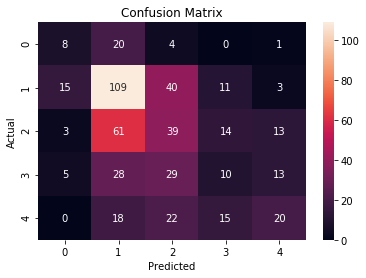

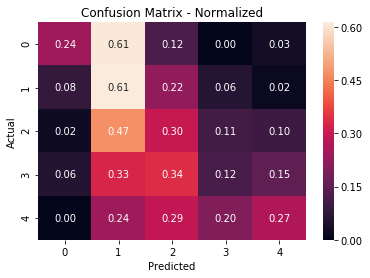

max features: 1500
ngram range: (1, 2)
estimator: None


In [205]:
model_metrics(gs4)
print("max features:", gs4.best_params_.get('cvec__max_features'))
print("ngram range:", gs4.best_params_.get('cvec__ngram_range'))
print("estimator:", gs4.best_params_.get('bag__base_estimator'))

## Random Forests?

In [206]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier())
])


params = {
    'cvec__max_features': [200,500,1000,1500],
    'cvec__tokenizer': [LemmaTokenizer()],
    'cvec__stop_words': [custom_stop_words],
    'cvec__lowercase': [True],
    'cvec__ngram_range': [(1,2), (2,3)],
    'rf__n_estimators': [10,50,100],
    'rf__max_depth': [4,5,6],
    'rf__max_features': ['auto', 20] 
}


gs5 = GridSearchCVProgressBar(pipe, params, cv = 3, verbose = 1)

gs5.fit(X_train, y_train);

Fitting 3 folds for each of 144 candidates, totalling 432 fits
[                                        ] 0% | 0.00 sec | GridSearchCV 

[ParallelProgressBar(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[........................................] 100% | 308.01 sec | GridSearchCV 


[ParallelProgressBar(n_jobs=1)]: Done 432 out of 432 | elapsed:  5.1min finished


Train Accuracy: 0.4960053262316911
Test Accuracy: 0.39520958083832336



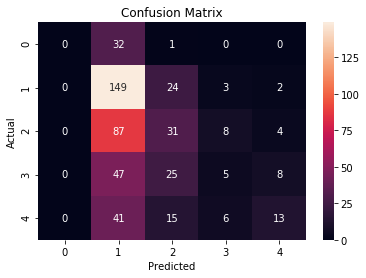

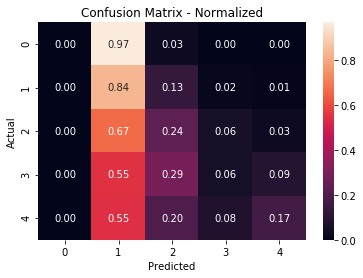

max features: 1500
ngram range: (1, 2)
n_estimators: None
max tree depth: None
max features: None


In [207]:
model_metrics(gs5)
print("max features:", gs4.best_params_.get('cvec__max_features'))
print("ngram range:", gs4.best_params_.get('cvec__ngram_range'))
print("n_estimators:", gs4.best_params_.get('rf__n_estimators'))
print("max tree depth:", gs4.best_params_.get('rf__max_depth'))
print("max features:", gs4.best_params_.get('rf__max_features'))


# MultinomialNB with the other data!

MAJOR IDEA: 
    GET THE TOP OH 1500 TEXT FEATURES FROM THE CVEC, APPEND *THAT* TO THE DATA FRAME, AND DO ANOTHER PIPELINE WITH A STANDARD SCALAR INSTEAD OF THE CVEC THING. 
    
    

Our best model was the gs3. We will fit this model to vocabulary, get the data, append, and run another model to try to optimize further!

In [305]:
gs2.best_params_
# but calling .get_feature_names() raises an error - we need to fit transform it!

{'lr__class_weight': None,
 'lr__penalty': 'l2',
 'tvec__lowercase': True,
 'tvec__max_features': 500,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': ['i',
  'me',
  'my',
  'myself',
  'we',
  'our',
  'ours',
  'ourselves',
  'you',
  'yourself',
  'yourselves',
  'he',
  'him',
  'his',
  'himself',
  'she',
  'her',
  'hers',
  'herself',
  'it',
  'its',
  'what',
  'which',
  'who',
  'whom',
  'these',
  'those',
  'am',
  'is',
  'are',
  'was',
  'were',
  'be',
  'been',
  'being',
  'have',
  'has',
  'had',
  'having',
  'do',
  'does',
  'did',
  'doing',
  'the',
  'but',
  'because',
  'as',
  'until',
  'while',
  'of',
  'at',
  'by',
  'iffor',
  'with',
  'about',
  'against',
  'between',
  'into',
  'through',
  'after',
  'above',
  'below',
  'to',
  'from',
  'up',
  'down',
  'in',
  'out',
  'on',
  'off',
  'over',
  'under',
  'again',
  'further',
  'then',
  'once',
  'here',
  'there',
  'when',
  'where',
  'why',
  'how',
  'all',
  'any',
  'both',

In [301]:
tvec = TfidfVectorizer(lowercase = True,
                      #max_features = 500,
                      ngram_range = (1,2),
                      stop_words = custom_stop_words,
                      tokenizer = LemmaTokenizer())
best_500 = tvec.fit_transform(df['text'])
best_500_df = pd.DataFrame(best_500.toarray(), columns = tvec.get_feature_names())
best_500_df.set_index(df['rarity'], inplace=True)

In [302]:
X_train_fitted = tvec.fit_transform(X_train)

In [303]:
len(tvec.get_feature_names())

135

In [304]:
tvec.get_feature_names()

['&',
 '& catacomb',
 "'s",
 "'s rumble",
 'armor',
 'attack',
 'boomsday',
 'boomsday project',
 'cardset_basic',
 'cardset_blackrock',
 'cardset_blackrock mountain',
 'cardset_classic',
 'cardset_goblins',
 'cardset_goblins v',
 'cardset_hall',
 'cardset_hall fame',
 'cardset_journey',
 "cardset_journey un'goro",
 'cardset_knights',
 'cardset_knights frozen',
 'cardset_kobolds',
 'cardset_kobolds &',
 'cardset_mean',
 'cardset_mean street',
 'cardset_naxxramas',
 'cardset_one',
 'cardset_one night',
 'cardset_rastakhan',
 "cardset_rastakhan 's",
 'cardset_rise',
 'cardset_rise shadow',
 'cardset_the',
 'cardset_the boomsday',
 'cardset_the grand',
 'cardset_the league',
 'cardset_the witchwood',
 'cardset_whispers',
 'cardset_whispers old',
 'catacomb',
 'const',
 'cost',
 'damage',
 'durability',
 'explorer',
 'faction_alliance',
 'faction_horde',
 'faction_neutral',
 'fame',
 'frozen',
 'frozen throne',
 'gadgetzan',
 'gnome',
 'god',
 'golem',
 'grand',
 'grand tournament',
 'heal

In [ ]:
X.reset_index(inplace = True)
X.drop(columns = 'rarity', inplace = True)

In [ ]:
X_all = df.join(X)

In [ ]:
X_all.head()

In [46]:
#concat the data frame
X.head()

,0 battlecry discover,0 battlecry discover a,0 battlecry discover a spell,0 if your,0 if your hero,0 if your hero wa,0 if youre,0 if youre holding,0 if youre holding a,0 if youve,...,youve played thisgame,youve restored 10,youve restored 10 health,youve restored 10 health this,youve restored 5,youve restored 5 health,youve restored 5 health this,youve spent spell,youve summoned this,youve summoned this game
rarity,,,,,,,,,,,,,,,,,,,,,
Free,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Free,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Free,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Free,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Free,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
numerical_columns = X_all._get_numeric_data().columns
features = [c for c in numerical_columns if c != 'rarity_value']
X = X_all[features]
y = X_all['rarity_value']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

## One More LogReg Attempt

In [ ]:
df_deck_archetypes = pd.read_csv('decklist_df.csv')

In [ ]:
df_deck_archetypes.head()

In [ ]:
df_deck_archetypes.stack().value_counts()

So of our 23 decks, each containing 30 cards, we have 283 unique cards. 

Normalize this! We need to definitely normalize using the CLASS of each card, and the following:

1 Archetypes of Druid: ['Token Druid']   
5 Archetypes of Hunter: ['Deathrattle Hunter' 'Mech Hunter' 'Midrange Hunter' 'Secret Hunter' 'Spell Hunter']   
2 Archetypes of Mage: ['Burn Mage' 'Khadgar Mage']   
3 Archetypes of Paladin: ['Control Paladin' 'Mech Paladin' 'Secret Paladin']   
2 Archetypes of Priest: ['Resurrect Priest' 'Silence Priest']   
3 Archetypes of Rogue: ['Miracle Rogue' 'Tempo Rogue' 'Thief Rogue']   
3 Archetypes of Shaman: ['Big Shaman' 'Murloc Shaman' 'Shudderwock Shaman']   
2 Archetypes of Warlock: ['Handlock' 'Zoo Warlock']   
4 Archetypes of Warrior: ['Big Warrior' 'Bomb Warrior' 'Control Warrior' 'Dragon Warrior']   


In [ ]:
# sudo code
df_deck_name_here = pd.DataFrame
   columns = card_name, everything else from the card set dataframe.
  

- make a model for spells, weapons, minions MASK!!! (predicting rarity)
- add feature of word count on card


- predict a decks winrate against each class
   each row a single deck

- 


log reg: probability of winning vs losing
make dummies for every card of current standard format (kinda nlp), class winrate against other classes (
get decklist into that, 





# Predict Rarity with Deck Win Data

In [ ]:
To build off in the 